In [273]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')


In [274]:
landslides_df = pd.read_csv('data\Global_Landslide_Catalog_Export.csv', sep=';')
print(landslides_df.head())

   source_name                                        source_link event_id  \
0          AGU  https://blogs.agu.org/landslideblog/2008/10/14...      684   
1    Oregonian  http://www.oregonlive.com/news/index.ssf/2009/...      956   
2     CBS News  https://www.cbsnews.com/news/dozens-missing-af...      973   
3      Reuters  https://in.reuters.com/article/idINIndia-41450...    1,067   
4  The Freeman  http://www.philstar.com/cebu-news/621414/lands...    2,603   

               event_date  event_time  \
0  08/01/2008 12:00:00 AM         NaN   
1  01/02/2009 02:00:00 AM         NaN   
2  01/19/2007 12:00:00 AM         NaN   
3  07/31/2009 12:00:00 AM         NaN   
4  10/16/2010 12:00:00 PM         NaN   

                                         event_title  \
0      Sigou Village, Loufan County, Shanxi Province   
1                                Lake Oswego, Oregon   
2  San Ramon district, 195 miles northeast of the...   
3                                   Dailekh district   
4   

In [275]:
columns = landslides_df.columns
print(columns)

Index(['source_name', 'source_link', 'event_id', 'event_date', 'event_time',
       'event_title', 'event_description', 'location_description',
       'location_accuracy', 'landslide_category', 'landslide_trigger',
       'landslide_size', 'landslide_setting', 'fatality_count', 'injury_count',
       'storm_name', 'photo_link', 'notes', 'event_import_source',
       'event_import_id', 'country_name', 'country_code',
       'admin_division_name', 'admin_division_population',
       'gazeteer_closest_point', 'gazeteer_distance', 'submitted_date',
       'created_date', 'last_edited_date', 'longitude', 'latitude'],
      dtype='object')


In [276]:
# list of columns that contain descriptive strings (not categories as strings)
text_columns = ['source_name', 'source_link', 'event_title', 'event_description', 'location_description',
                'storm_name', 'photo_link', 'notes', 'event_import_source', 'country_name', 'admin_division_name']

# list of unuseful columns (text_columns + other such as submitted_date, created_date, etc.)
unuseful_columns = text_columns + ['submitted_date', 'created_date', 'last_edited_date', 'event_id']

# drop columns that contain descriptive strings
landslides_df = landslides_df.drop(unuseful_columns, axis=1)

In [277]:
# get the data types of each column
print(landslides_df.dtypes)

event_date                    object
event_time                   float64
location_accuracy             object
landslide_category            object
landslide_trigger             object
landslide_size                object
landslide_setting             object
fatality_count                object
injury_count                 float64
event_import_id               object
country_code                  object
admin_division_population     object
gazeteer_closest_point        object
gazeteer_distance            float64
longitude                    float64
latitude                     float64
dtype: object


In [278]:
# add correct data types to each column (make a distinction between categorical (values are repeated) and descriptive (unique strings) columns)
# filtered columns are:
# event_date                    object format: 08/01/2008 12:00:00 AM
# event_time                   float64
# location_accuracy             object
# landslide_category            object
# landslide_trigger             object
# landslide_size                object
# landslide_setting             object
# fatality_count                object
# injury_count                 float64
# event_import_id               object
# country_code                  object
# admin_division_population     object
# gazeteer_closest_point        object
# gazeteer_distance            float64
# longitude                    float64
# latitude                     float64

# split event_date into event_date and event_time in correct format
landslides_df['event_date'] = pd.to_datetime(landslides_df['event_date'], format='%m/%d/%Y %H:%M:%S %p').dt.date
landslides_df['event_time'] = pd.to_datetime(landslides_df['event_date'], format='%m/%d/%Y %H:%M:%S %p').dt.time
# convert event_date to float64 and drop event_time
landslides_df['event_date'] = pd.to_numeric(landslides_df['event_date'], errors='coerce')
landslides_df = landslides_df.drop('event_time', axis=1)


landslides_df['location_accuracy'] = landslides_df['location_accuracy'].astype('category')
landslides_df['landslide_category'] = landslides_df['landslide_category'].astype('category')
landslides_df['landslide_trigger'] = landslides_df['landslide_trigger'].astype('category')
landslides_df['landslide_size'] = landslides_df['landslide_size'].astype('category')
landslides_df['landslide_setting'] = landslides_df['landslide_setting'].astype('category')
landslides_df['fatality_count'] = pd.to_numeric(landslides_df['fatality_count'], errors='coerce')
landslides_df['injury_count'] = pd.to_numeric(landslides_df['injury_count'], errors='coerce')
landslides_df['event_import_id'] = landslides_df['event_import_id'].astype('category')
landslides_df['country_code'] = landslides_df['country_code'].astype('category')
landslides_df['admin_division_population'] = pd.to_numeric(landslides_df['admin_division_population'], errors='coerce')
landslides_df['gazeteer_closest_point'] = landslides_df['gazeteer_closest_point'].astype('category')
landslides_df['gazeteer_distance'] = pd.to_numeric(landslides_df['gazeteer_distance'], errors='coerce')
landslides_df['longitude'] = pd.to_numeric(landslides_df['longitude'], errors='coerce')
landslides_df['latitude'] = pd.to_numeric(landslides_df['latitude'], errors='coerce')




In [279]:
# show data types of each column
print(landslides_df.dtypes)

event_date                    float64
location_accuracy            category
landslide_category           category
landslide_trigger            category
landslide_size               category
landslide_setting            category
fatality_count                float64
injury_count                  float64
event_import_id              category
country_code                 category
admin_division_population     float64
gazeteer_closest_point       category
gazeteer_distance             float64
longitude                     float64
latitude                      float64
dtype: object


In [280]:
# get categorical columns
categorical_columns = landslides_df.select_dtypes(include=['category']).columns
print(categorical_columns)

Index(['location_accuracy', 'landslide_category', 'landslide_trigger',
       'landslide_size', 'landslide_setting', 'event_import_id',
       'country_code', 'gazeteer_closest_point'],
      dtype='object')


In [281]:
# Display the first few rows of the dataset
landslides_df.head(100)

,event_date,location_accuracy,landslide_category,landslide_trigger,landslide_size,landslide_setting,fatality_count,injury_count,event_import_id,country_code,admin_division_population,gazeteer_closest_point,gazeteer_distance,longitude,latitude
0,NaN,unknown,landslide,rain,large,mine,11.0,NaN,684,CN,0.0,Jingyang,41.02145,107.4500,32.5625
1,NaN,5km,mudslide,downpour,small,unknown,0.0,NaN,956,US,NaN,Lake Oswego,0.60342,-122.6630,45.4200
2,NaN,10km,landslide,downpour,large,unknown,10.0,NaN,973,PE,NaN,San Ramón,0.85548,-75.3587,-11.1295
3,NaN,unknown,landslide,monsoon,medium,unknown,1.0,NaN,"1,067",NP,NaN,Dailekh,0.75395,81.7080,28.8378
4,NaN,5km,landslide,tropical_cyclone,medium,unknown,0.0,NaN,"2,603",PH,NaN,Cebu City,2.02204,123.8978,10.3336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,10km,landslide,downpour,medium,unknown,0.0,NaN,"4,196",PH,NaN,Consolacion,7.06201,123.9100,10.4200
96,NaN,exact,landslide,rain,large,natural_slope,0.0,0.0,NaN,NaN,NaN,NaN,NaN,88.4920,27.5930
97,NaN,10km,landslide,downpour,large,unknown,NaN,NaN,"4,346",US,NaN,Myrtle Point,14.54271,-124.0100,42.9744
98,NaN,1km,landslide,downpour,medium,unknown,NaN,NaN,"4,565",IN,NaN,Jutogh,8.68139,77.1029,31.0226


In [282]:

# # Convert categorical columns to numeric using Label Encoding
# label_encoder = LabelEncoder()
# for col in categorical_columns:
#     landslides_df[col] = label_encoder.fit_transform(landslides_df[col].astype(str))

# Convert categorical columns to numeric using One-Hot Encoding
landslides_df = pd.get_dummies(landslides_df, columns=categorical_columns)

# Handle missing values
landslides_df['fatality_count'].fillna(0, inplace=True)  # Replace missing fatality counts with 0
# Remove commas
landslides_df.replace(',', '', regex=True, inplace=True)
landslides_df['admin_division_population'] = pd.to_numeric(landslides_df['admin_division_population'], errors='coerce')
# Drop when missing population values with mean
landslides_df.dropna(subset=['admin_division_population'], inplace=True)

# Display the cleaned dataset
print("\nCleaned Dataset:")
landslides_df.head()



Cleaned Dataset:


,event_date,fatality_count,injury_count,admin_division_population,gazeteer_distance,longitude,latitude,location_accuracy_100km,location_accuracy_10km,location_accuracy_1km,...,gazeteer_closest_point_Īdgāh,gazeteer_closest_point_Ōtsuchi,gazeteer_closest_point_Ōzu,gazeteer_closest_point_Şabyā,gazeteer_closest_point_Željezno Polje,gazeteer_closest_point_Živinice,gazeteer_closest_point_Јегуновце,gazeteer_closest_point_‘Aiea,gazeteer_closest_point_‘Alāqahdārī Aṯghar,gazeteer_closest_point_‘Ibrī
0,NaN,11.0,NaN,0.0,41.02145,107.4500,32.5625,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,NaN,2.0,NaN,0.0,55.18512,100.0845,23.8900,False,True,False,...,False,False,False,False,False,False,False,False,False,False
27,NaN,4.0,NaN,0.0,0.63292,116.6620,-8.5073,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35,NaN,2.0,NaN,0.0,2.33966,123.2260,9.2900,False,False,False,...,False,False,False,False,False,False,False,False,False,False
40,NaN,2.0,NaN,0.0,32.28507,84.2279,27.9447,False,False,False,...,False,False,False,False,False,False,False,False,False,False


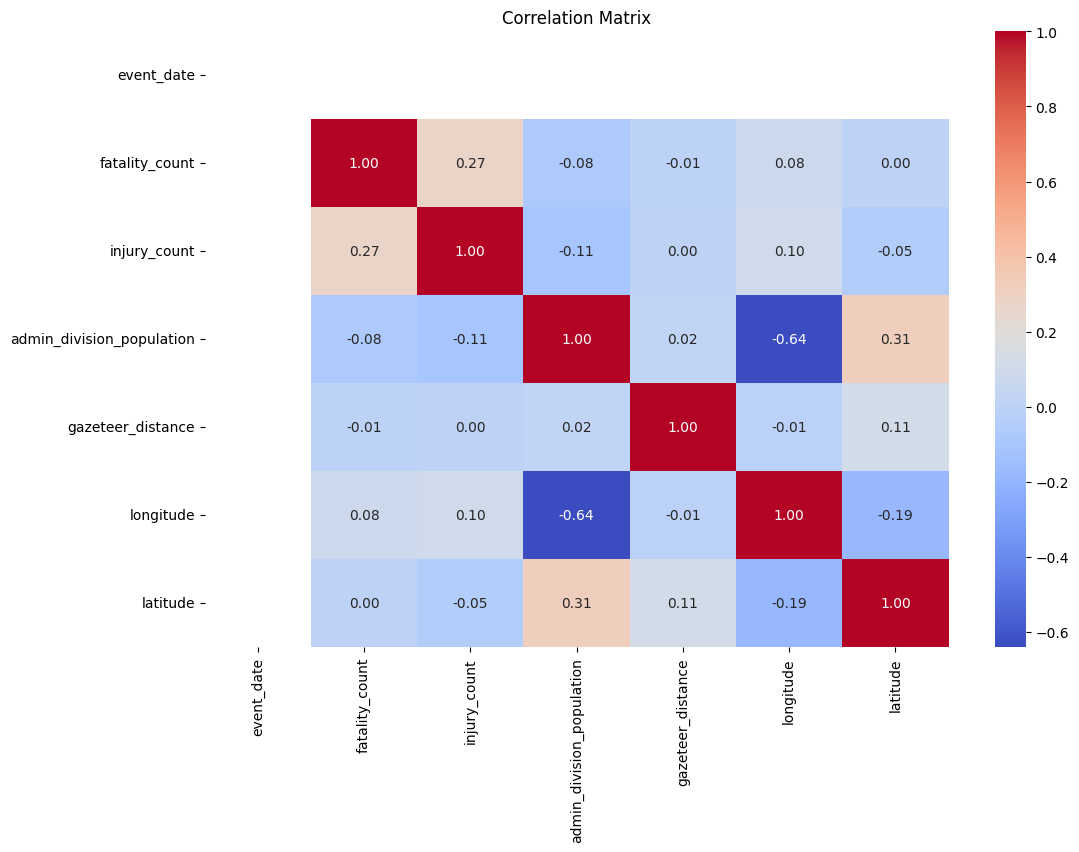

ValueError: feature_names must be string, and may not contain [, ] or <

In [283]:

# Calculate correlation matrix for all numeric columns
numeric_cols = landslides_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = landslides_df[numeric_cols].corr()


# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Split the dataset into features (X) and target (y)
X = landslides_df.drop('fatality_count', axis=1)
y = landslides_df['fatality_count']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model (/!\ there are still cayegorical features in the dataset)
model = XGBRegressor(objective ='reg:squarederror')
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# show important features (plot)
from xgboost import plot_importance
plot_importance(model)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("\nMean Squared Error:", mse)


In [ ]:
# test with 20 random samples from the test set
print("\nTest predictions:")
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).sample(20)

# Optionally, you can save the model for later use
# model.save_model('xgboost_model.model')


Test predictions:


,Actual,Predicted
68,0,0.084897
3583,3,1.994498
5436,0,2.362180
5248,0,0.005576
7451,2,1.035223
3207,0,0.073451
6843,0,0.922002
1616,0,-0.001186
9312,0,-0.020184
8106,0,0.048093
